# Identifying '16 and '18 House of Representative Candidates

### PreReqs

- *1976-2018-house.xlsx* files from https://electionlab.mit.edu/data, which has information on all House district races with votes per candidate/totals per district
- Downloaded the fec_data files from the *download_fec* jupyter notebook

### Imports

In [5]:
import os
from pyspark.sql import SparkSession
import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from functools import reduce
from pyspark.sql.functions import col, asc
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType, DoubleType, DateType
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

/home/hs4cf/.local/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [6]:
spark = SparkSession \
    .builder \
    .getOrCreate()

sc = spark.sparkContext

### Functions:

In [7]:
def parse_file(file_name, file_header):
    '''Tool to load in an FEC file with associated header and produce a Spark Dataframe'''   

    #load data frame and split by delimiter  
    df_temp = sc.textFile(file_name).map(lambda row: [elem for elem in row.split('|')])
    
    #load separate header csv file and prepare schema 
    #assumes all values are STRING TYPE for simplicity
    head_temp = pd.read_csv(file_header)
    fields = [*[typ.StructField(h[:], typ.StringType(), True) for h in head_temp.columns]]
    schema = typ.StructType(fields)
    
    #finalize spark dataframe
    df = spark.createDataFrame(df_temp, schema)
    
    return df

### Read-in Population of Candidates from FEC Data:

In [8]:
df_candidate_20 = parse_file('./fec_data/cn/cn20.txt', './fec_data/cn/cn_header_file.csv')
df_candidate_18 = parse_file('./fec_data/cn/cn18.txt', './fec_data/cn/cn_header_file.csv')
df_candidate_16 = parse_file('./fec_data/cn/cn16.txt', './fec_data/cn/cn_header_file.csv')

dfs = [df_candidate_20, df_candidate_18, df_candidate_16]

#join all three data frames
df_candidate = reduce(DataFrame.unionAll, dfs)

###########################################
####### NEED TO Make PYSPARK ##############
###########################################

#converting to a pandas DF for ease of working with
df_candidate = df_candidate.select('*').toPandas() 

### Read-in Candidate election results from MIT Election Center Data:

In [10]:
#data from https://electionlab.mit.edu/data
df_MIT = pd.read_excel('1976-2018-house.xlsx')
df_filter18 = df_MIT[(df_MIT.year == 2018) & (df_MIT.writein == False)]
df_filter16 = df_MIT[(df_MIT.year == 2016) & (df_MIT.writein == False)]

---
### *One-Time Process [Do Not Repeat]:*

Identify 2016 and 2018 House of Representative Candidates from the above file.  
- Fuzzywuzzy was used to string match Candidate names from FEC and MIT Election center data
- Provides score 0-100 for string match, returned most likely name
- String match was good for the majority, but these files were downloaded and visually scanned for accuracy

**2016:**

In [ ]:
# df_house16 = df_candidate[(df_candidate.CAND_ELECTION_YR == '2016')&(df_candidate.CAND_OFFICE == 'H')]
# df_house16 = df_house16.drop_duplicates(subset = ['CAND_ID']).reset_index(drop=True)

# #fuzzywuzzy match attempt between names in FEC/MIT data sets
# df_house16['name_match'] = 0
# df_house16['score_match'] = 0

# name_match = []
# score_match = []

# for name in df_house16.CAND_NAME:
#     ratio = process.extract(name, df_filter16.candidate, limit = 1, scorer=fuzz.token_set_ratio)
#     name_match.append(ratio[0][0])
#     score_match.append(ratio[0][1])   

# df_house16['name_match'] = name_match
# df_house16['score_match'] = score_match

# df_house16.to_csv('16tempfile.csv')

**2018:**

In [ ]:
# df_house18 = df_candidate[(df_candidate.CAND_ELECTION_YR == '2018')&(df_candidate.CAND_OFFICE == 'H')]
# df_house18 = df_house18.drop_duplicates(subset = ['CAND_ID']).reset_index(drop=True)

# df_house18['name_match'] = 0
# df_house18['score_match'] = 0

# #fuzzywuzzy match attempt between names in FEC/MIT data sets
# name_match = []
# score_match = []

# for name in df_house18.CAND_NAME:
#     ratio = process.extract(name, df_filter18.candidate, limit = 1, scorer=fuzz.token_set_ratio)
#     name_match.append(ratio[0][0])
#     score_match.append(ratio[0][1])   

# df_house18['name_match'] = name_match
# df_house18['score_match'] = score_match

# df_house18.to_csv('18tempfile.csv')

---
### Join FEC and MIT Data based on one-time work above

**2016:**

In [12]:
#This is a version of the FEC data with columns added to join to the MIT Election Center Data
df_h16 = pd.read_excel('16tempfile.xlsx')

#filter for matches + need to remove any candidates without a CAND_PCC value. Candidates without this value do not have financial information available
df_h16 = df_h16[(df_h16.match == 1) & (df_h16.CAND_PCC.notna() == True)]
df_h16_final = df_h16.merge(df_filter16, left_on='match_id', right_index=True)

**2018:**

In [13]:
#This is a version of the FEC data with columns added to join to the MIT Election Center Data
df_h18 = pd.read_excel('18tempfile.xlsx')

#filter for matches + need to remove any candidates without a CAND_PCC value. candidates without this value do not have financial information available
df_h18 = df_h18[(df_h18.match == 1)&(df_h18.CAND_PCC.notna() == True)]
df_h18_final = df_h18.merge(df_filter18, left_on='match_id', right_index=True)

**Join 2016 and 2018:**

In [14]:
df_house = pd.concat([df_h16_final,df_h18_final])
df_house['VOTE_percent'] = df_house['candidatevotes']/df_house['totalvotes']

cols = ['CAND_ID',
        'CAND_NAME',
        'CAND_PTY_AFFILIATION',
        'CAND_ELECTION_YR',
        'CAND_OFFICE_ST',
        'CAND_OFFICE',
        'CAND_OFFICE_DISTRICT',
        'CAND_ICI',
        'CAND_STATUS',
        'CAND_PCC',
        'CAND_CITY',
        'CAND_ST',
        'CAND_ZIP',
        'candidatevotes',
        'totalvotes',
        'VOTE_percent']

df_house = df_house[cols]

#identify winners based on greater than 50% of votes
df_house['WINNER'] = np.where(df_house['VOTE_percent'] >= 0.5, 1, 0)

**Clean Joined Data Based on races with a Winner and races with sum vote totals <= 100%**

In [15]:
#identify elections we don't have a winner designated
#data is unfortunately not clean from source, some includes primary votes instead of final election results... 
#cleaning races without a winner based on given criteria and where vote % is >100% (some are over due to duplication or error?)

a_temp = df_house.groupby(['CAND_ELECTION_YR','CAND_OFFICE_ST','CAND_OFFICE_DISTRICT']).sum()
b_temp = a_temp[(a_temp.VOTE_percent > 1) | (a_temp.WINNER != 1)].reset_index()
c_temp = b_temp[['CAND_ELECTION_YR','CAND_OFFICE_ST','CAND_OFFICE_DISTRICT']]

#filter out races we don't have clean data 
keys = list(c_temp.columns.values)
i1 = df_house.set_index(keys).index
i2 = c_temp.set_index(keys).index
df_house = df_house[~i1.isin(i2)]

### Final '16 and '18 List of House of Representative Information

In [30]:
df_house

,CAND_ID,CAND_NAME,CAND_PTY_AFFILIATION,CAND_ELECTION_YR,CAND_OFFICE_ST,CAND_OFFICE,CAND_OFFICE_DISTRICT,CAND_ICI,CAND_STATUS,CAND_PCC,CAND_CITY,CAND_ST,CAND_ZIP,candidatevotes,totalvotes,VOTE_percent,WINNER
1,H6VA04061,"MCEACHIN, ASTON DONALD MR.",DEM,2016,VA,H,4.0,C,C,C00610964,HENRICO,VA,23227.0,200136,346656,0.577333,1
2,H4NJ10085,"FRASER, AARON WALTER",DEM,2016,NJ,H,10.0,C,N,C00668566,JERSEY CITY,NJ,7305.0,1746,222771,0.007838,0
3,H0CA27085,"SCHIFF, ADAM",DEM,2016,CA,H,28.0,I,C,C00343871,LOS ANGELES,CA,90017.0,210883,270409,0.779867,1
4,H0IL11052,"KINZINGER, ADAM",REP,2016,IL,H,16.0,I,C,C00458877,CHANNAHON,IL,604105623.0,259722,259853,0.999496,1
6,H6WA09025,"SMITH, D ADAM",DEM,2016,WA,H,9.0,I,C,C00304709,RENTON,WA,98057.0,205165,281482,0.728874,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,H6AL04098,"ADERHOLT, ROBERT B. REP.",REP,2018,AL,H,4.0,I,C,C00313247,HALEYVILLE,AL,355651158.0,184255,230969,0.797748,1
1064,H8AL02197,"ISNER, TABITHA KAY",DEM,2018,AL,H,2.0,C,P,C00657437,MONTGOMERY,AL,36106.0,86931,226230,0.384259,0
1065,H0AL02087,"ROBY, MARTHA",REP,2018,AL,H,2.0,I,C,C00462143,MONTGOMERY,AL,361062448.0,138879,226230,0.613884,1
1066,H4AL01123,"BYRNE, BRADLEY ROBERTS",REP,2018,AL,H,1.0,I,C,C00545673,FAIRHOPE,AL,36532.0,153228,242617,0.631563,1


Export for further integration into project

In [17]:
df_house.to_csv('df_house.csv')

Text(0.5, 1, 'Candiate Party vs Vote Percent')

<Figure size 1080x720 with 0 Axes>

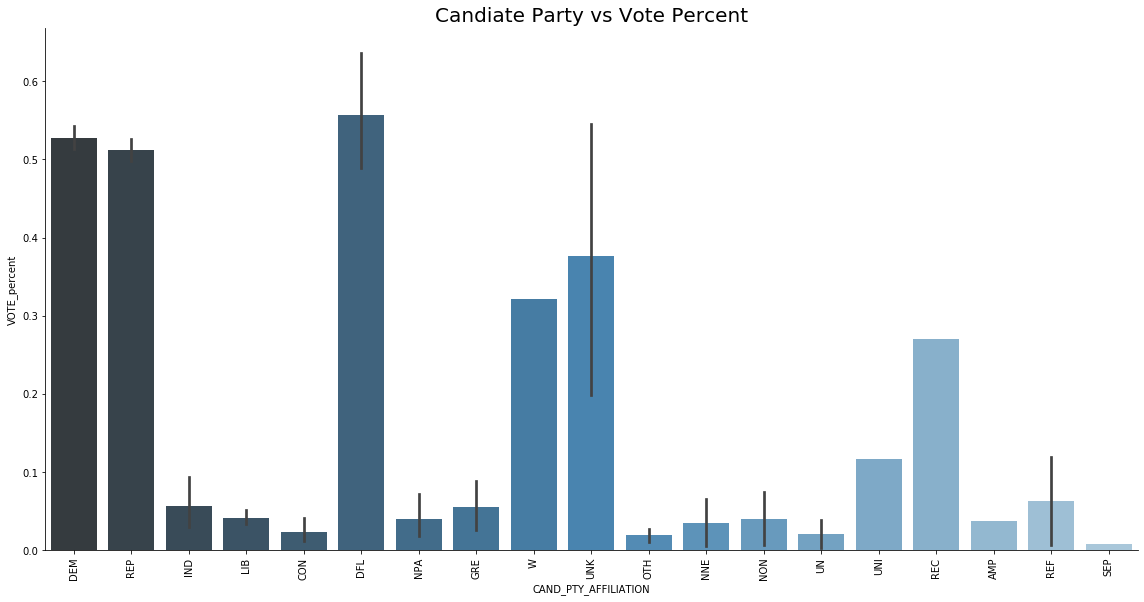

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(15,10))
plt.tight_layout()

#df_house_sort= df_house.sort_values('VOTE_percent')
votepercent = sns.catplot("CAND_PTY_AFFILIATION", "VOTE_percent", data=df_house, kind="bar", size=8, aspect=2, legend=False, palette="Blues_d")

votepercent.set_xticklabels(rotation=90)

plt.title('Candiate Party vs Vote Percent', size= "20")

### According to the bar graph summary above, the top 5 Candidate party affilations are Democratic, Republican, Democratic-Farmer-Labor, Working Families, and Unknown Parites. 

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3695: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1, 'Candiate Party vs Winner')

<Figure size 1080x720 with 0 Axes>

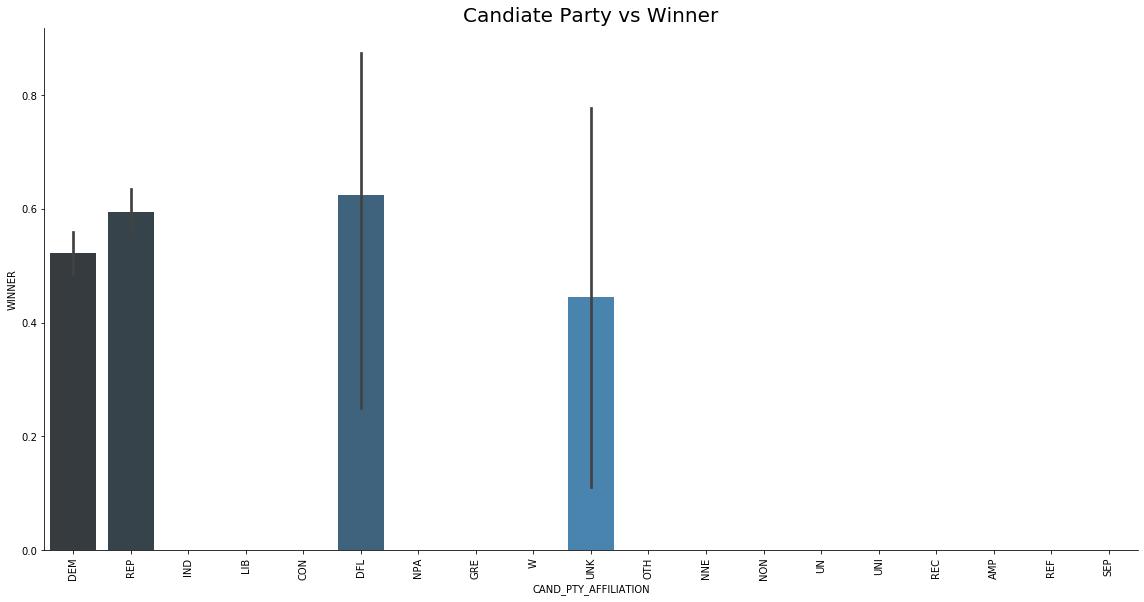

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(15,10))
plt.tight_layout()

#df_house_sort= df_house.sort_values('VOTE_percent')
votepercent = sns.catplot("CAND_PTY_AFFILIATION", "WINNER", data=df_house, kind="bar", size=8, aspect=2, legend=False, palette="Blues_d")

votepercent.set_xticklabels(rotation=90)

plt.title('Candiate Party vs Winner', size= "20")

### According to the bar graph summary above, the parties with Winners are Democratic, Republican, Democratic-Farmer-Labor, and Unknown Parites. 